
```Author: Yao Gahounzo```

This program solves the 2D-diffusion problem using the continuous Galerkin (CG) method. The method is implemented with two different boundary conditions, Dirichlet, Neumann, and Robin. The CG method derivation and all the necessary mathematics are in the file [CG_method.pdf](https://github.com/yao24/SWE_2D_Diffusion/blob/main/CG_method.pdf).

This program call the module func_2D which contains all the subroutines needed in the CG method.


In [1]:
%matplotlib notebook
%pylab
from scipy.interpolate import griddata
from matplotlib import cm
#import pandas as pd
#from time import perf_counter
#from sympy import*
#import warnings
#warnings.filterwarnings('ignore')

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Call module func_2D
#from change_func import*
from module_2D_diffusion_bdf2_3 import*

In [3]:
# Domain of integration, look into func_2D module to add your own problem or initial condition

def domain(icase):
    
    
    if(icase == 1):
        ax = -1 ; bx = 1 ; coeff = 1.0
    elif(icase == 2):
        ax = 0 ; bx = 2*pi ; coeff = 1.0
    elif(icase == 3):
        ax = -1 ; bx = 1 ; coeff = 1.0
    elif(icase == 4):
        ax = -1 ; bx = 1 ; coeff = 0.01
    elif(icase == 5):
        ax = 0 ; bx = 3 ; coeff = 1/25
    
    print("==========================================")
    print("Problem: Diffusion")
    print("Domain: [{}, {}]".format(ax,bx)) 
    print("Diffusivity: {}".format(coeff)) 
    
    return ax, bx, coeff

# Boundary conditions 
    
def bc_type(x_boundary,y_boundary):
    
    bound = array([x_boundary,y_boundary])
    
    sbound = ["Dirichlet", "Neumann", "Robin"]
    nbound = [5,4,8]
    
    st = ""
    
    for i in range(3):
        
        if(nbound[i] in bound):
            st += sbound[i] + " & "
            
    print("Boundary conditions: ",st)
    
    print("==========================================\n") 

In [4]:
order = array([2])        # polynomial order
N_element = array([8,16,32])
kstages = 4
cfl = 0.25
dt = 1e-2
Tfinal = 0.1

time_method = "BDF2"      # IRK, BDF2 or BDF3
integration_type = 1      # % = 1 is inexact and = 2 is exact
iplot = False             # plot the solution
icase = 1                 # select icase: 1,2,3,4

alpha = 1              
beta = -1#-1/2                  # Dirichlet: alpha = 0, beta = 1
                               # Neumann: alpha = 1, beta = 0
                               # Robin: alpha = 1, beta != 0
        
x_boundary = [5,5]    # Bottom and Top (x = -1 and x = +1)
y_boundary = [5,5]    # Left and Right (y = -1 and x = +1)
    
# Domain and diffusion coefficient

ax,bx,c = domain(icase)
bc_type(x_boundary,y_boundary)

len_el = len(N_element)
len_pol = len(order)
l2e_norm = zeros((len_pol, len_el))
max_norm = zeros((len_pol, len_el))

Nv = N_element
    
for iN,N in enumerate(order):
    
    cfl = 50.0#1/(N+1)       # cfl number
    
    N = order[iN]
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1

    wall = 0
    

    for e, nel in enumerate(Nv):
            
        Nelx = nel; Nely = nel
        Nx = Nelx*N+1
        Ny = Nely*N+1
        Np = Nx*Ny
        Ne = Nelx*Nely
        Nbound = 2*Nx + 2*(Ny-2)
        Nside = 2*Ne + Nelx + Nely
        
        tic = perf_counter()
        
    
        qe, q,coord,intma,ntime,tf = diffusion_solver(N,Q,Ne, Np, ax, bx, Nelx, Nely, Nx, Ny, Nbound,Nside,\
                                             icase,Tfinal,c,cfl,kstages,time_method,alpha,beta,\
                                             x_boundary,y_boundary)
        
        #print("\twalltime: {}".format(tf))
            
        #Compute Norm
        
        #print(abs(q-qe))
        
        top = sum((q - qe)**2)
        bot = sum(qe**2)

        e2 = sqrt(top/bot)
        
        print("\tl2_norm = {:.4e}".format(e2))
        print("\twalltime: {}".format(tf))
        
        l2e_norm[iN,e] = e2
        
        
        

Problem: Diffusion
Domain: [-1, 1]
Diffusivity: 1.0
Boundary conditions:  Dirichlet & 

N = 2, nel = 64, Np = 289
	dt = 2.3810e-03
	Number of time steps = 42
	l2_norm = 3.4088e-03
	walltime: 0.19956798799999986
N = 2, nel = 256, Np = 1089
	dt = 1.6863e-04
	Number of time steps = 593
	l2_norm = 2.6076e-04
	walltime: 1.806984678
N = 2, nel = 1024, Np = 4225
	dt = 1.1203e-05
	Number of time steps = 8926
	l2_norm = 1.8089e-05
	walltime: 74.020912588


In [5]:
#intma

In [6]:
xmin = min(coord[:,0])
xmax = max(coord[:,0])
ymin = min(coord[:,1])
ymax = max(coord[:,1])
xe = coord[:,0]
ye = coord[:,1]
nx = 200
ny = 200
dx = (xmax-xmin)/nx
dy = (ymax-ymin)/ny
x1 = arange(xmin,xmax+dx,dx)
y1 = arange(ymin,ymax+dy,dy)
xi,yi = meshgrid(x1,y1)

<IPython.core.display.Javascript object>


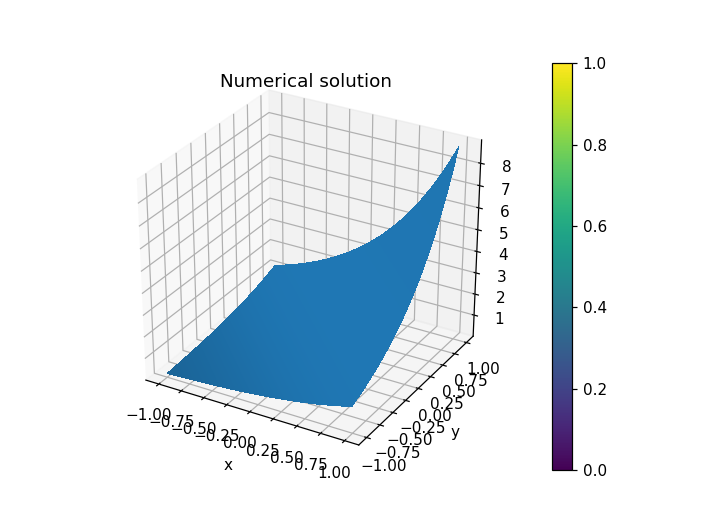

/var/folders/26/w_m7zvh1665dw364xwg3qhsh0000gp/T/ipykernel_77675/3228479372.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = fx.plot_surface(xi,yi,q_2d,rstride = 1, cstride = 1,antialiased=False)


In [7]:

q_2d = griddata((xe,ye),q,(xi,yi), method='cubic')

fig = figure(2)
fx = fig.add_subplot(111, projection='3d')
surf = fx.plot_surface(xi,yi,q_2d,rstride = 1, cstride = 1,antialiased=False)
fig.colorbar(surf)

title("Numerical solution")
xlabel("x")
ylabel("y")

show()

<IPython.core.display.Javascript object>


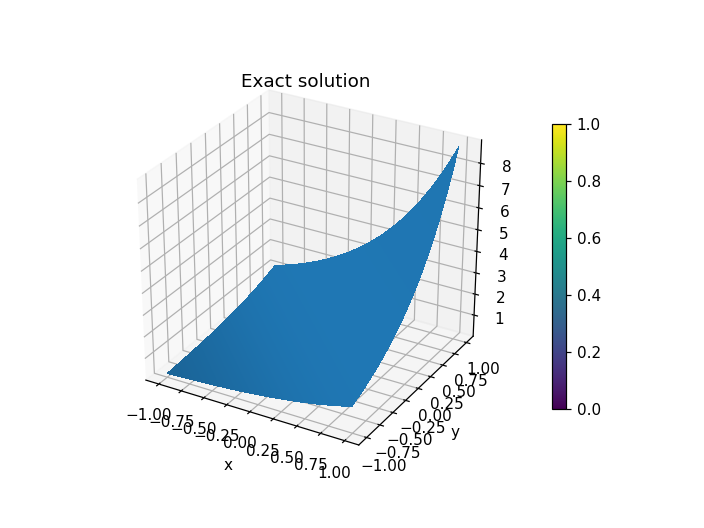

/var/folders/26/w_m7zvh1665dw364xwg3qhsh0000gp/T/ipykernel_77675/2511905161.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = fx.plot_surface(xi,yi,qe_2d,rstride = 1, cstride = 1,antialiased=False)


In [8]:
qe_2d = griddata((xe,ye),qe,(xi,yi), method='cubic')

fig = figure(3)
fx = fig.add_subplot(111, projection='3d')
surf = fx.plot_surface(xi,yi,qe_2d,rstride = 1, cstride = 1,antialiased=False)
fig.colorbar(surf,anchor=(0, 0.3), shrink=0.7)
title("Exact solution")
xlabel("x")
ylabel("y")
show()

<IPython.core.display.Javascript object>


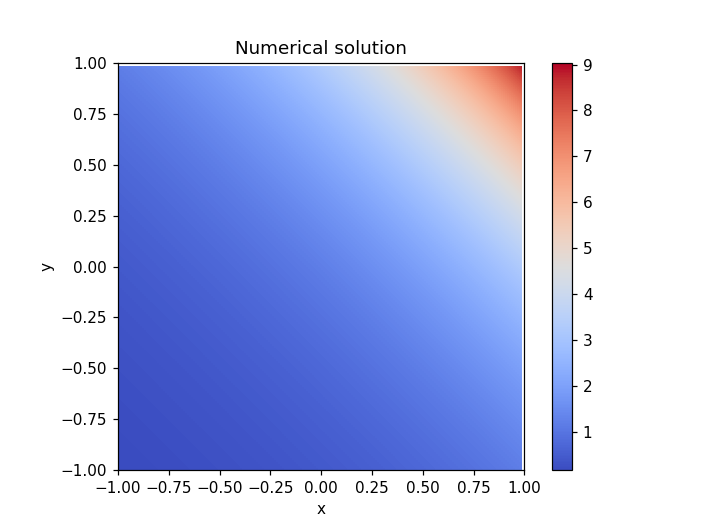

In [9]:
figure(4)
imshow(q_2d, extent=[ax, bx, ax, bx],origin='lower',cmap=cm.coolwarm)
colorbar()
clim(q.min(), q.max())
title("Numerical solution")
xlabel("x")
ylabel("y")
show()

In [10]:
print("min_q  = ",q.min())
print("min_qe = ",qe.min())

print("\nmax_q  = ",q.max())
print("max_qe = ",qe.max())

min_q  =  0.16529888822158836
min_qe =  0.16529888822158836

max_q  =  9.025013499434223
max_qe =  9.025013499434223


<IPython.core.display.Javascript object>


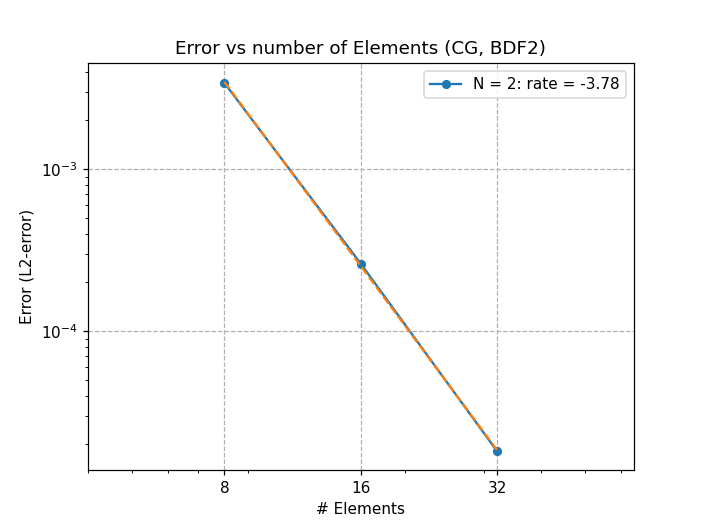

In [11]:
import cg_graphics           # import cg_graphics module

figure(5)
clf()

for i,N in enumerate(order):

    if(N >= 2):
        p = polyfit(log(Nv[:3]), log(l2e_norm[i][:3]), 1)
    else:

        p = polyfit(log(Nv), log(l2e_norm[i]), 1)

    loglog(Nv, l2e_norm[i], '-o',markersize=5, label = 'N = {:d}: rate = {:.2f}'.format(N,p[0]))

    loglog(Nv, exp(polyval(p,log(Nv))), '--')

cg_graphics.set_xticks(Nv)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of Elements ({:s}, {:s})'.format('cg'.upper(), time_method))
grid(axis='both',linestyle='--')
legend()
show()